## Imports / CSV

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Concatenate

### Target variable 'class' depicts the identification of a celestial body based on image. Thee classes are galaxy, star, or quasar.

In [3]:
df = pd.read_csv('D:\GIT\classification_project\Personal Projects\star_classification.csv')
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470



    obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
    alpha = Right Ascension angle (at J2000 epoch)
    delta = Declination angle (at J2000 epoch)
    u = Ultraviolet filter in the photometric system
    g = Green filter in the photometric system
    r = Red filter in the photometric system
    i = Near Infrared filter in the photometric system
    z = Infrared filter in the photometric system
    run_ID = Run Number used to identify the specific scan
    rereun_ID = Rerun Number to specify how the image was processed
    cam_col = Camera column to identify the scanline within the run
    field_ID = Field number to identify each field
    spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
    class = object class (galaxy, star or quasar object)
    redshift = redshift value based on the increase in wavelength
    plate = plate ID, identifies each plate in SDSS
    MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
    fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [4]:
#some columns depict id values which will create bias if use din the model
df = df.drop(['obj_ID', 'run_ID','rerun_ID','cam_col', 'field_ID','spec_obj_ID','fiber_ID'], axis = 1)
df

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187
...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000,9374,57749
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895,7626,56934
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366,2764,54535
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040,6751,56368


In [5]:
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

## Train Test Split before Data Cleaning

In [6]:
#separating the classes within the target variable to be used for classificaiton neural network.
df_encoded = pd.get_dummies(df, columns=['class'])
df_encoded

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,class_GALAXY,class_QSO,class_STAR
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354,True,False,False
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158,True,False,False
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592,True,False,False
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039,True,False,False
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374,57749,True,False,False
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626,56934,True,False,False
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764,54535,True,False,False
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751,56368,True,False,False


In [7]:
#changing each class to 1 if true 0 if false
df_encoded[['class_GALAXY','class_QSO','class_STAR']] = df_encoded[['class_GALAXY','class_QSO','class_STAR']].astype(int)
df_encoded

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,class_GALAXY,class_QSO,class_STAR
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354,1,0,0
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158,1,0,0
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592,1,0,0
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039,1,0,0
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374,57749,1,0,0
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626,56934,1,0,0
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764,54535,1,0,0
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751,56368,1,0,0


In [8]:
#making target all 3 columns
X = df_encoded.drop(['class_GALAXY','class_QSO','class_STAR'], axis = 1)
y = df_encoded[['class_GALAXY','class_QSO','class_STAR']]

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, stratify = y)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((75000, 10), (25000, 10), (75000, 3), (25000, 3))

## Data Cleaning

In [10]:
xtrain.isna().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
redshift    0
plate       0
MJD         0
dtype: int64

In [11]:
xtrain

,alpha,delta,u,g,r,i,z,redshift,plate,MJD
71408,132.253515,29.765789,23.72459,23.49002,21.85124,19.25895,17.81140,-0.000045,1588,52965
40765,200.246206,33.244470,23.07521,21.91270,20.90862,20.04779,19.66064,0.661599,3980,55331
10364,124.725978,49.176199,24.05616,23.00133,21.33651,20.63907,19.89567,0.455152,7318,56990
25804,116.257064,50.408949,22.14923,21.02219,20.57510,20.52208,20.26726,0.000098,3668,55478
18254,14.934257,0.887475,19.01291,17.64017,17.11520,16.91190,16.67018,0.000067,1083,52520
...,...,...,...,...,...,...,...,...,...,...
98286,226.657602,30.478172,19.53977,17.90090,17.18822,16.86502,16.60755,0.058025,1844,54138
60547,156.664594,58.515585,24.68712,22.23488,20.42790,19.57653,19.13139,0.434860,7089,56661
84181,194.863484,36.068939,24.45473,21.57348,19.50620,18.71981,18.41639,0.437045,2031,53848
52078,203.917748,67.151719,20.94444,18.84810,17.67747,17.19618,16.88009,0.179162,497,51989


In [12]:
ytrain

,class_GALAXY,class_QSO,class_STAR
71408,0,0,1
40765,1,0,0
10364,1,0,0
25804,0,0,1
18254,0,0,1
...,...,...,...
98286,1,0,0
60547,1,0,0
84181,1,0,0
52078,1,0,0


## Scaling

In [13]:
#simple scaling for data prep
xtrain = pd.DataFrame(MinMaxScaler().fit_transform(xtrain), columns = xtrain.columns)
xtrain

,alpha,delta,u,g,r,i,z,redshift,plate,MJD
0,0.367351,0.476993,0.647287,0.615608,0.609078,0.431776,0.414693,0.001414,0.107646,0.185281
1,0.556225,0.511169,0.614264,0.540868,0.561350,0.466571,0.508224,0.095649,0.302418,0.508329
2,0.346440,0.667691,0.664149,0.592452,0.583016,0.492651,0.520112,0.066245,0.574220,0.734844
3,0.322914,0.679803,0.567174,0.498672,0.544463,0.487491,0.538906,0.001434,0.277013,0.528400
4,0.041453,0.193276,0.407680,0.338417,0.369276,0.328252,0.356972,0.001430,0.066526,0.124522
...,...,...,...,...,...,...,...,...,...,...
74995,0.629593,0.483992,0.434473,0.350772,0.372974,0.326185,0.353805,0.009684,0.128491,0.345440
74996,0.435161,0.759447,0.696236,0.556134,0.537010,0.445784,0.481456,0.063355,0.555574,0.689924
74997,0.541273,0.538918,0.684418,0.524794,0.490341,0.407996,0.445292,0.063666,0.143718,0.305844
74998,0.566424,0.844293,0.505906,0.395654,0.397746,0.340791,0.367589,0.026937,0.018810,0.052021


In [14]:
xtest = pd.DataFrame(MinMaxScaler().fit_transform(xtest), columns = xtest.columns)
xtest

,alpha,delta,u,g,r,i,z,redshift,plate,MJD
0,0.435372,0.582837,0.999001,0.999314,0.682523,0.588982,0.999413,0.025218,0.696849,0.894866
1,0.331818,0.713145,0.998936,0.999097,0.471369,0.381593,0.998968,0.038692,0.346959,0.543692
2,0.674091,0.633759,0.998989,0.999259,0.698218,0.572878,0.999179,0.000491,0.672502,0.859093
3,0.965580,0.454571,0.999121,0.999366,0.628733,0.495604,0.999184,0.064313,0.491491,0.676816
4,0.078663,0.178075,0.998858,0.999155,0.563752,0.478128,0.999192,0.033096,0.065956,0.178318
...,...,...,...,...,...,...,...,...,...,...
24995,0.038417,0.233266,0.999306,0.999280,0.607939,0.466179,0.999144,0.000549,0.338246,0.583697
24996,0.706291,0.407798,0.999120,0.999248,0.542215,0.437633,0.999073,0.057683,0.318541,0.552294
24997,0.053879,0.175383,0.998783,0.999013,0.466185,0.386160,0.998975,0.006759,0.100480,0.289732
24998,0.587025,0.175448,0.998969,0.999327,0.595623,0.461737,0.999113,0.000130,0.307060,0.549290


### My main focus of this project is to see how a nueral network model will do, and be able to tweak it to increase the score.

In [15]:
#sequential modelling
model = Sequential()
model.add(Dense(64, input_dim = 10, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation = 'sigmoid'))

d:\GIT\classification_project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam')
model.fit(xtrain, ytrain, epochs = 50, batch_size = 1000, validation_data = [xtest, ytest])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6038 - val_loss: 0.5698
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5043 - val_loss: 0.5602
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3948 - val_loss: 0.5716
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3222 - val_loss: 0.6293
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2716 - val_loss: 0.6122
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2286 - val_loss: 0.5751
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1961 - val_loss: 0.5099
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1746 - val_loss: 0.4533
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1592 - val_loss: 0.4856
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1479 - val_loss: 0.4612
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1374 - val_loss: 0.4626
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1310 - val_lo

In [17]:
pred = model.predict(xtest)

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


## Prediction Overview

In [18]:
pred

array([[9.9873614e-01, 1.5951496e-03, 3.1640977e-07],
       [9.9992305e-01, 4.0993214e-05, 1.0728201e-09],
       [1.3646533e-01, 9.2736926e-05, 7.1786666e-01],
       ...,
       [1.2938610e-01, 3.1815182e-06, 6.9034922e-01],
       [3.2456875e-02, 7.0681399e-06, 9.4205016e-01],
       [9.9990898e-01, 1.4183929e-04, 1.8127460e-19]], dtype=float32)

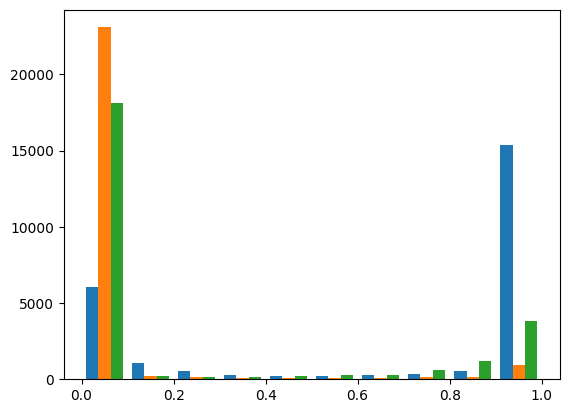

In [31]:
plt.hist(pred);

In [20]:
pred_df = pd.DataFrame(pred)
pred_df.columns = ['Galaxy','Quasar','Star']
pred_df

,Galaxy,Quasar,Star
0,0.998736,0.001595,3.164098e-07
1,0.999923,0.000041,1.072820e-09
2,0.136465,0.000093,7.178667e-01
3,0.999940,0.000079,4.272999e-16
4,0.999600,0.000051,6.670165e-07
...,...,...,...
24995,0.051835,0.000016,9.142058e-01
24996,0.999947,0.000040,4.861843e-14
24997,0.129386,0.000003,6.903492e-01
24998,0.032457,0.000007,9.420502e-01


In [ ]:
#finding argmax to classify each row
empty_list = []
for number in pred:
    empty_list.append(np.argmax(number))

In [ ]:
#Series to show prediction value counts
pd.Series(empty_list).value_counts()

0    17111
2     6489
1     1400
Name: count, dtype: int64

## Scoring

In [27]:
auc_score = roc_auc_score(ytest, pred)
print("AUC Score: ", auc_score)

AUC Score:  0.9415510417561618
